Делаем вариационный автоэнкодер (VAE) в Keras | #29 нейросети на Python

In [41]:

import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Embedding,LSTM, GRU, Flatten, Dropout, Bidirectional, Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [42]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.reshape(x_train, (len(x_train), 28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28,28,1))

In [43]:
hidden_dim = 2
batch_size = 60

def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

In [44]:
input_img = Input(batch_shape=(batch_size, 28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x) 

In [45]:
def noiseer(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.)
    return K.exp(z_log_var / 2) * N + z_mean

In [46]:
h = Lambda(noiseer, output_shape=(hidden_dim,))([z_mean, z_log_var])

In [47]:
input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28,28,1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name='vae')


In [48]:
def vae_loss(x,y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_loss 

vae.compile(optimizer='adam', loss=vae_loss)

In [49]:
vae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5


2025-01-04 22:17:05.437225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 91.1079
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 49.1634
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 49.0393
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 48.4803
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 48.0334


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


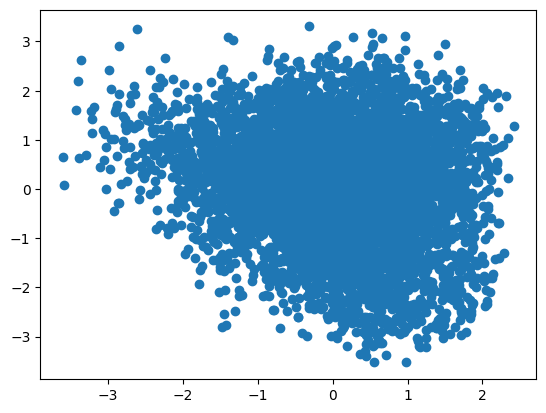

In [51]:
h = encoder.predict(x_test[:6000], batch_size=batch_size)
plt.scatter(h[:,0], h[:,1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

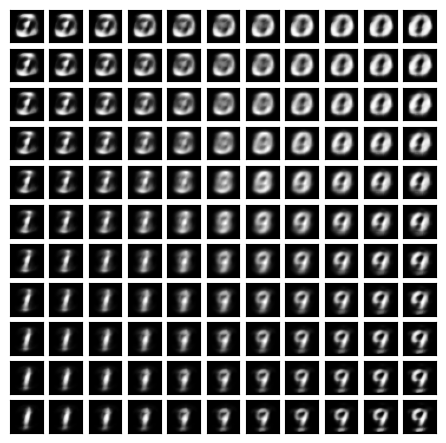

In [54]:
n = 5

total = 2*n + 1

plt.figure(figsize=(total/2, total/2))

num = 1

for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num +=1
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)